# Task 2
## Optical character recognition (OCR)

There will be simmilar functions usead as in the previous tasks, but there will be many more obstacles to overcome.

In [42]:
import numpy as np
from numpy import rot90
from numpy.fft import fft2, ifft2

import PIL as pillow
from PIL import Image, ImageFile

import os
import random
from math import ceil
from matplotlib import pyplot as plt


# For some reason all my files are "corrupted" and it won't work without this magic line :)
ImageFile.LOAD_TRUNCATED_IMAGES = True

Font:
Times New Roman 11 Bold
180%

In [43]:
def to_grayscale(image, invert_colors=False):
    grayscale = image.convert('L')
    if invert_colors:
        return pillow.ImageOps.invert(grayscale)
    return grayscale

def from_grayscale(image):
    image_array = np.asarray(image)
    return np.array(
        [[(val, val, val) for val in row] for row in image_array]
    )

def scale_image(image, factor):
    return image.resize(np.array(image.size) * factor)

## Font characters

Characters for each font are saved in *img\task2\characters\\(font-name)* or in *img/task2/characters\/(font-name)* if you are on Linux.
Each character will be a class with fields containing its:
  - ASCII character
  - Grayscale image
  - Calculated (later on) correlation matrix

In [44]:
TEXTS_DIRECTORY = os.path.join("img", "task2", "texts")
CHARACTERS_DIRECTORY = os.path.join("img", "task2", "characters")

LATIN_LETTERS = [chr(i) for i in range(ord('a'), ord('z') + 1)]

class Character:
    def __init__(self, char, path, color=None):
        self.char = char
        self.image = to_grayscale(
            image=Image.open(path),
            invert_colors=True
        )
        self.color = color if color is not None else [random.randint(0, 255) for _ in range(3)]

    def display(self, scale_factor=1):
        display(scale_image(image=self.image, factor=scale_factor))


def initialize_characters(font_name, chars=LATIN_LETTERS):
    characters = []
    for char in chars:
        filename = char + ".png"
        characters.append(Character(
            char=char, path=os.path.join(CHARACTERS_DIRECTORY, font_name, filename)))
    return characters


def show_characters(characters, items_in_row=7):
    fig = plt.figure(figsize=(10, 7))
    rows_num, columns_num = ceil(len(characters) / items_in_row), items_in_row
    for i, character in enumerate(characters):
        fig.add_subplot(rows_num, columns_num, i+1)
        plt.imshow(from_grayscale(character.image))
        plt.axis('off')

Let's load and display Times New Roman Characters

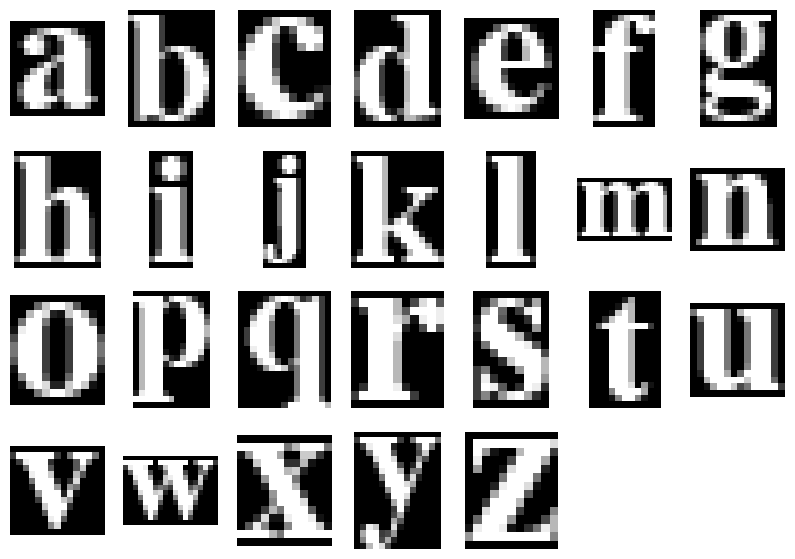

In [45]:
times_new_roman_characters = initialize_characters("times_new_roman")

show_characters(times_new_roman_characters)

## Text image

Everything here is simmilar to *galia.png* file from previous task.

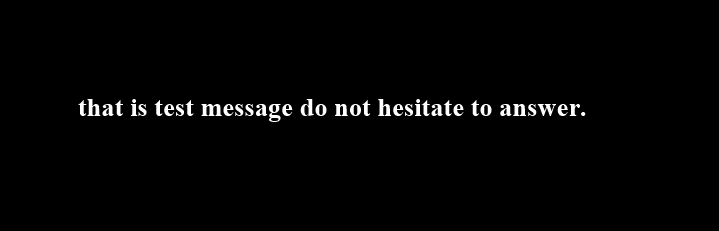

In [46]:
text = to_grayscale(
    image=Image.open(os.path.join(TEXTS_DIRECTORY, "text1.png")),
    invert_colors=True
)
display(text)

## Calculating correlation

Since this time we have multiple characters (presumably 26) there will also be multiple correlatin matricies.
We can also take one of two normalization strategies:
- Just as before: each character's correlation matrix is being scaled, so that its elements are between [0, 1].
- Each character's correlation matrix is divided by the value being character's image's correlatin with itself.

We will see later on which strategy works better.

In [47]:
def calculate_correlation(whole_image, searched_image, normalize=True):
    def rot180(arr):
        return rot90(rot90(arr))

    image_width, image_height = whole_image.size

    result = ifft2(
        fft2(whole_image) * fft2(rot180(searched_image), s=(image_height, image_width))
    ).real
    if normalize:
        result /= np.abs(np.max(result))
    return result

In [48]:
def calculate_all_characters_correlations(characters, whole_image, normalize_each=False):
    for character in characters:
        character.correlation = calculate_correlation(
            whole_image=whole_image,
            searched_image=character.image,
            normalize=not normalize_each
        )
        if normalize_each:
            self_correlation = np.max(calculate_correlation(
                whole_image=character.image,
                searched_image=character.image,
                normalize=False
            ))
            character.correlation /= self_correlation

In [49]:
def mark_found_elements(image_arr, correlation, certainty, selection_size, color):
    found_locations = []
    for y in range(correlation.shape[0]):
        for x in range(correlation.shape[1]):
            if correlation[y, x] > certainty:
                found_locations.append((y, x))

    result = image_arr.copy()
    for (y, x) in found_locations:
        for dy in range(0, selection_size[0], np.sign(selection_size[0])):
            for dx in range(0, selection_size[1], np.sign(selection_size[1])):
                result[y + dy, x + dx] = color
    return result


def mark_and_display_all_letters(characters, certainity=0.95):
    result = from_grayscale(text)
    for character in characters:
        result = mark_found_elements(
            image_arr=result,
            correlation=character.correlation,
            certainty=certainity,
            selection_size=(4, -12),
            color=character.color
        )
    result = Image.fromarray(result)
    display(result)

Let's see how many letters have been identified with at least 0.96

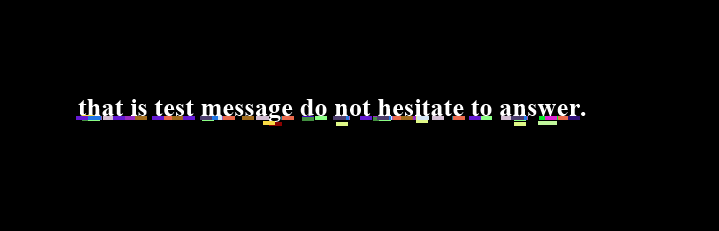

In [50]:
calculate_all_characters_correlations(times_new_roman_characters, whole_image=text)
mark_and_display_all_letters(
    times_new_roman_characters, certainity=0.96)

### Extracting characters locations
Now we need to extract characters locations from correlation matricies. I decided to simply take all spots, where correlation is high enough.

In [51]:
def get_all_char_locations(characters, certainity=0.95):
    locations = {}
    for character in characters:
        correlation = character.correlation
        for y in range(correlation.shape[0]):
            for x in range(correlation.shape[1]):
                if correlation[y, x] > certainity:
                    if (y, x) not in locations or locations[(y, x)][1] < correlation[y, x]:
                        locations[(y, x)] = character.char, correlation[y, x]

    found_characters = list(locations.items())
    found_characters.sort(key=lambda x: x[0][1])
    found_characters.sort(key=lambda x: x[0][0])
    return found_characters

## Converting character locations into string

That is arguably the hardest part of the whole task. We need to somehow convert list of locations into a string. After taking into consideration I have decided to stick to a hyperparameter approach.
Position of each pixel of image with size **(width, hight)** is represented as **(x, y)**.
Function's arguments' meaning is following:
- **x_radius**: If a character is identified at (x, y), than there will be no characters with coordinates **(x + d, y)**, where d ∈ **[-x_radius, x_radius]**.
- **y_radius**: If there is a line at y, then all characters with coordinates **(x, y + d)**, where **d ∈ [-y_radius, y_radius]** also belong to this line.
- **whitespace_width**: If the distance between two identified characters rounds up to **n**, there are **n-1** spaces between them.
- **alpha** (∈ [0, 1]): y is considered a full row (that absorbs characters in range of **y_radius**) only if there are at least **alpha * max_n** characters, where **max_n** is a row with the most characters.

In [52]:
def char_locations_to_string(char_locations, image_height, image_width, x_radius, y_radius, whitespace_width, alpha):
    # Making one line truly one line
    letters_in_line = [0 for i in range(image_height)]
    for ((y, _), _) in char_locations:
        letters_in_line[y] += 1
    lines_by_letters = [(i, num_of_letters) for i, num_of_letters in enumerate(letters_in_line)]
    lines_by_letters.sort(key=lambda x: x[1], reverse=True)

    true_line = [i for i in range(image_height)]
    for y, _ in lines_by_letters:
        if true_line[y] != y or letters_in_line[y] < alpha * lines_by_letters[0][1]:
            continue
        for dy in range(-y_radius, y_radius+1):
            if dy != 0 and 0 <= y + dy < image_height:
                letters_in_line[y] += letters_in_line[y + dy]
                letters_in_line[dy] = 0
                true_line[y + dy] = y

    old_locations = char_locations
    line_content = {}
    for (old_y, x), (char, score) in old_locations:
        y = true_line[old_y]
        new_record = (y, x), (char, score)
        if y not in line_content:
            line_content[y] = [new_record]
        else:
            line_content[y].append(new_record)

    # Remove multiple characters
    chars_by_line = []
    for y in sorted(list(line_content.keys())):
        # line_content[y].sort(key=lambda x: x[1])
        is_free = [True for _ in range(image_width)]
        letters_by_score = sorted(line_content[y], key=lambda x: x[1][1], reverse=True)
        remaining_letters = []
        for (y, x), char_score in letters_by_score:
            if is_free[x]:
                remaining_letters.append(((y, x), char_score))
                for dx in range(-x_radius, x_radius+1):
                    if 0 <= x + dx < image_width:
                        is_free[x + dx] = False
        chars_by_line.append(sorted(remaining_letters, key=lambda x: x[0][1]))

    result = ""
    for line in chars_by_line:
        prev_x = None
        for (_, x), (char, _) in line:
            if prev_x is not None:
                result += ' ' * (round((x - prev_x) / whitespace_width) - 1)
            result += char
            prev_x = x
        result += '\n'
    return result

### Image to text

We are now finally able read text from our image!

In [53]:
char_locations = get_all_char_locations(
    times_new_roman_characters, certainity=0.9)

txt = char_locations_to_string(
    char_locations, image_height=text.height, image_width=text.width,
    x_radius=5, y_radius=15, whitespace_width=11, alpha=0.3
)
print(txt)

tqoatis test umcssaqge dpo zmotibesipatc to aznsvwcr



The whole entusiasm is gone. Sure there is *some* correlation between image and output, but it is not what we expected...

Let's wrap all the steps into single function and try some more.

In [54]:
def read_text(text_filename, characters, x_radius=5, y_radius=15, whitespace_width=9, alpha=0.3, certainity=0.95, normalize_each=False, display_image=True):
    text_photo = to_grayscale(
        image=Image.open(os.path.join(TEXTS_DIRECTORY, text_filename)),
        invert_colors=True
    )
    if display_image:
        display(text_photo)

    calculate_all_characters_correlations(characters, whole_image=text_photo, normalize_each=normalize_each)
    char_locations = get_all_char_locations(characters, certainity)

    return char_locations_to_string(char_locations, image_height=text_photo.height, image_width=text_photo.width,
                                    x_radius=x_radius, y_radius=y_radius, alpha=alpha, whitespace_width=whitespace_width)

## Churchill's "We shall fight on the beaches..." speech

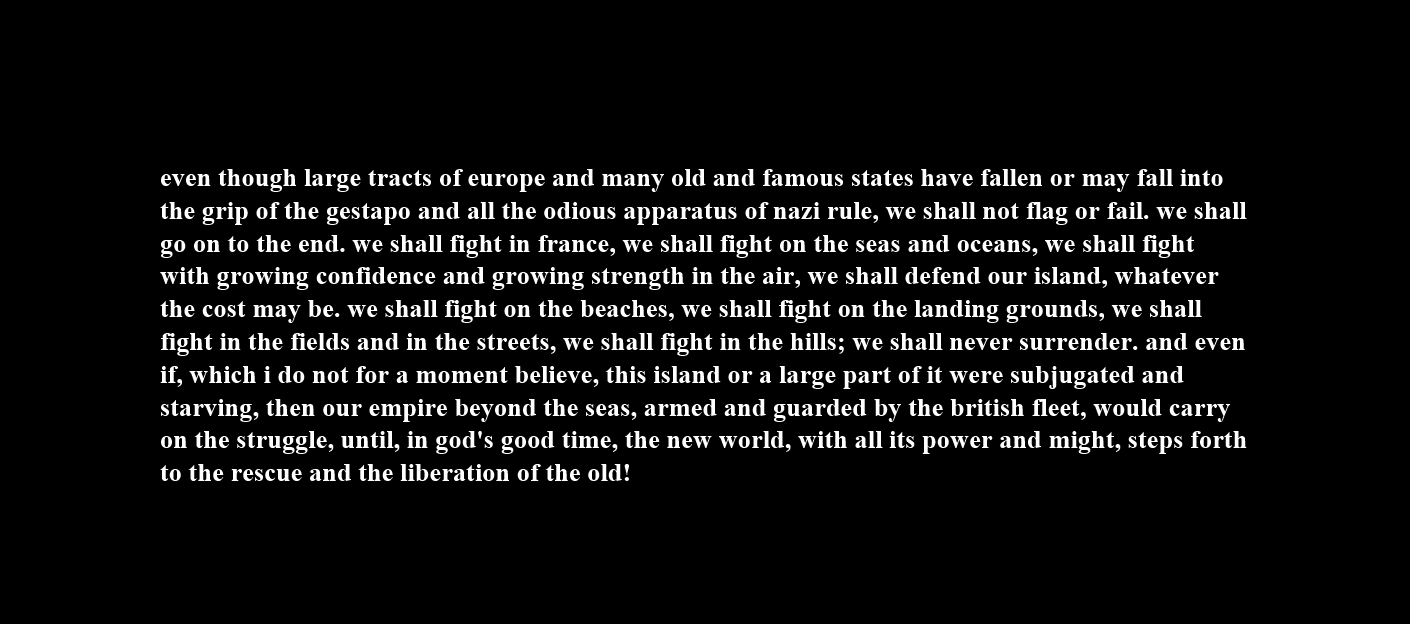

eventihougihlargetracts  f ea oipe axo xnan   lkd aodiarx  as statesihaveialken o  nmay taibiooto
tihe g iqp oi tihe gestaipo aod alk lke odbous aioiparatus oi oazi rule  weslkalk x tiiag o  taii v eslhalk
go  x  o tlhe end v eslhalkiigihtir traxce  weslkalb tigih   x lke  eas and ocean   we ihalbiiglht
vi lk gro wixg conf deoce and g ovingst englkio tlhe air  weslkalb deiend ourislaod  wiha eve
tihe cost nmay be v eslhailiigiht ontlhelbeaclkes  v eslhailiigiht ontlhelandixg g ounds  weslkalb
iiglktiontlheiieikds aodix tihestreets  v esihailiiglktiontlhelhilks  v eslhalk xeversa rexoer and e ex
if vihiclki do ootfor a nmorment belkeve  ihisisland or alargei ar  oiit v e esalbjugated and
starvixng tiheo our exnipire bey xo tlhesea  a rmed aod gaaroed b  tlhelbritislk tleet v oulkd carr
x lke tragxle uxtil ioo god s g od tirme tihe nev  wo ik  vi lk aili  ipov er ano nmiglht steio i rtih
to ihe rescue axo tlhelkberation oi lke oikd



In [55]:
txt = read_text(
    text_filename="we_shall_fight_on_the_beaches.png", characters=times_new_roman_characters, display_image=True,
    x_radius=5, y_radius=15, whitespace_width=11, alpha=0.3
)
print(txt)

Surely looks as if our Bulldog was reading out of it, but that is not exactly our goal here...

## Alternative normalization strategy

Let's try the other normalization strategy. Now each letter's correlation will be divided by the letter's correlation with itself.

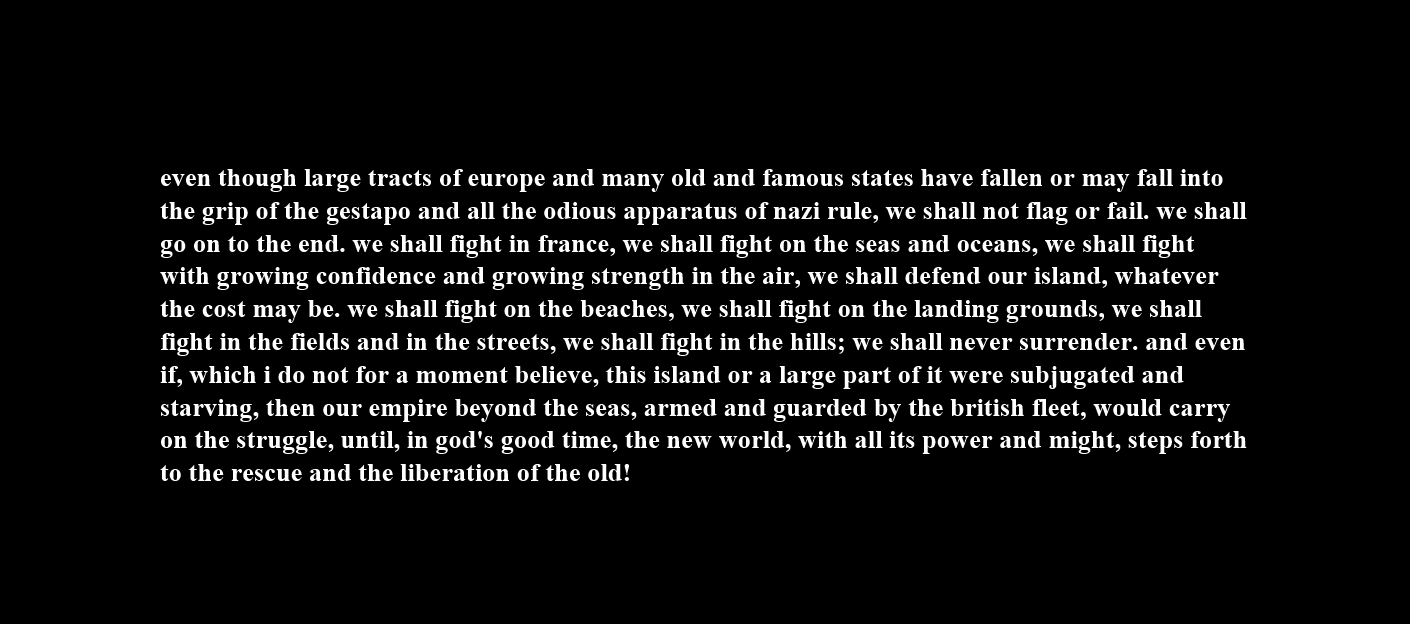

eveio tiomoooogioikargetracts of eoroiome aoomoioomauov olkd aoomdioaoommooos statesiomaveibaiioeio orioomay tnaiiiooto
tiome griio oi tiome gestaioo aoomd aiitiome odboooos aioioaoratos oiiomazi rolbe vwesiomaiiiomotiibaog or tnaii vwesiomail
go ooo to tiome eiomd vwesiomailiiogiotioo traoooce vwesiomali tiogiot ooo tiomeseas aoomo oceauos  vwesiomaliiiogiot
vwitio grovwioomg coooiiodbeiooce aoomd grovwioomgstreiomgtioioo tiome aior vwesiomali dbeioeiomo oooorislbaoomd vwiomatever
tiome costioomayibe vwesiomailiiogiot ooo tiomeloeaciomes  vwesiomailiiogiot ooo tiomeikauomoioomg grooomomds  vwesiomali
iiogiotioo tiomeiioeioos aoomdioo tiomestreets  vvesiomaiiiiogiotioo tiomeioiils  vwesiomailiomeversorreiomober auomo eveio
if vwioiocioi dboiomotfor aioooooommeiotibeiboeve tioisisikauomo or aikargeioart oiit vweresolojboogateo aoomd
staorvioomg tiomeio oooor eiooioioreibeyooomo tiomeseas  ariommed aoomd gomaorobeoibvtiomeloritisio tlbeet vwooolkd carrv
ooo tiomestromggloe oootil ioo god

In [56]:
txt = read_text(
    text_filename="we_shall_fight_on_the_beaches.png", characters=times_new_roman_characters,
    x_radius=5, y_radius=15, whitespace_width=11, alpha=0.3, certainity=0.8, normalize_each=True
)
print(txt)

And for some reason effect is even worse...
<br>
### Failure explanation
I expect the reason is that smaller letters (for example 'i') fit perfectly inside bigger letters achieving score of 1.0, thus winning the spot.
With the previous strategy they also had perfect match, but it was relative to their size. This way small letter's ability to fit everywhere was reduced by the fact that the best score they could possibly achieve was simply smaller, than that of the true letter.

## The last hope: FE-Schrift

The **Fälschungserschwerende Schrift** (eng. forgery-impeding typeface) is a font introduced specifically for **car licence plates** to prevent easy letter modification (that allows to steal fuel without consequences) as well as to **IMPROVE MACHINE READABILITY**!

That is exactly what we are looking for. If each letter will be significantly different, there will be way less missmatches.

Let's see how our new favourite font looks like

![German licence plate](img\task2\notebook_photos\plate1.png "German licence plate")

![German licence plate](img\task2\notebook_photos\plate2.png "German licence plate")

Nice.

And now the whole font:

![Fe-schrift](img\task2\notebook_photos\fe-schrift.png "Fe-schrift")

## FE-Schrift in action

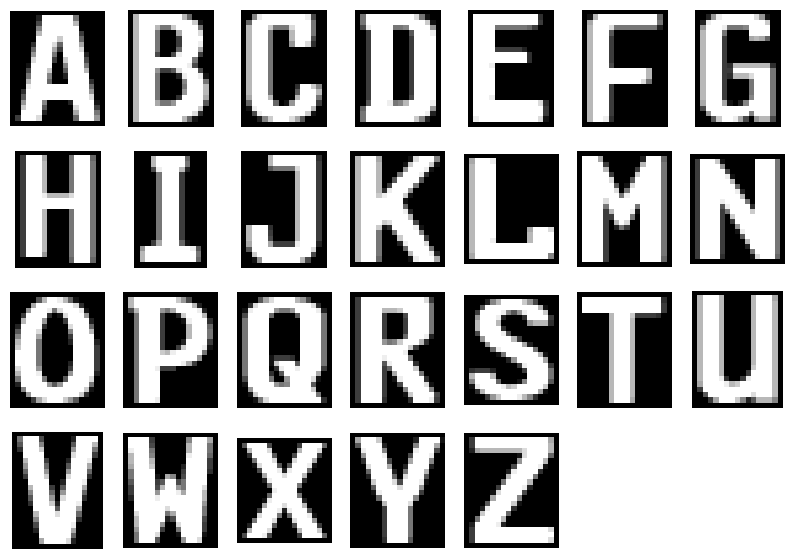

In [57]:
fe_schrift_characters = initialize_characters("fe_schrift")

show_characters(fe_schrift_characters)

## "We shall fight on the beaches..." in purely German font

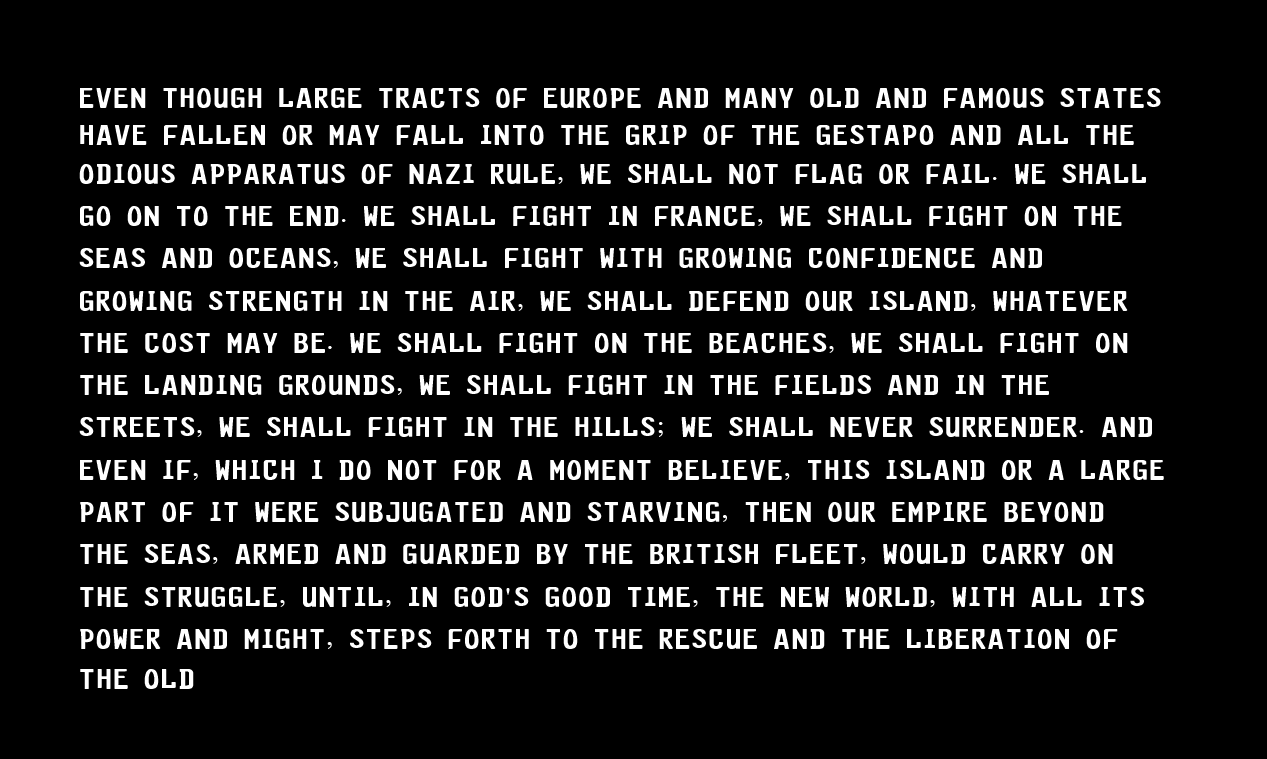

evex though large tracts of europe and many olj and famous states
haye falleq or may fall into the gr p of the gestapo akj all the
ojious apparatus of nazi rule xe shall xot flag or fail xe shall
go on to the enj xe shall fight in france xe shall fight oq the
seas and oceaxs xe shall fight xith groxing coxfijence and
groxixg strehgth ix the air xe shall oefenj ourislaxj xhatever
the cost may oe xe shall fight ox the oeaches xe shall fight ox
the laxjixg grounjs xe shall fightix the fielos and in the
streets xe shall fight ix the hills xe shall neyer surrenjer and
evex if xhich i jo xot for a momext selieve this islaqj or a large
part of it xere suojugateo anj staryixg then our empire oeyonj
the seas armed axj guarded by the or tish fleet xould carry on
the struggle until in gojs good time the nex xorlo xith all its
poxer and might steps forth to the rescue anj the liseratiox of
h  olo
the o j
h  o p



In [58]:
txt = read_text(
    text_filename="fe_churchill.png", characters=fe_schrift_characters,
    x_radius=12, y_radius=20, whitespace_width=18, alpha=0.4, certainity=0.9
)
print(txt)

Okay, it may not be perfect it I would call it decent.

### Little cheating
Let's cheat a little. In the following text, letter '**x**' was matched way too many times. In fact, it does not appear in this part of the speech even once!

We will simply remove the letter '**x**' from our characters together with other unused letter '**q**'. It may seem as a hirrible idea in general, but I think it's better to not identify two rarely used letters, than have every 6th read character as X.

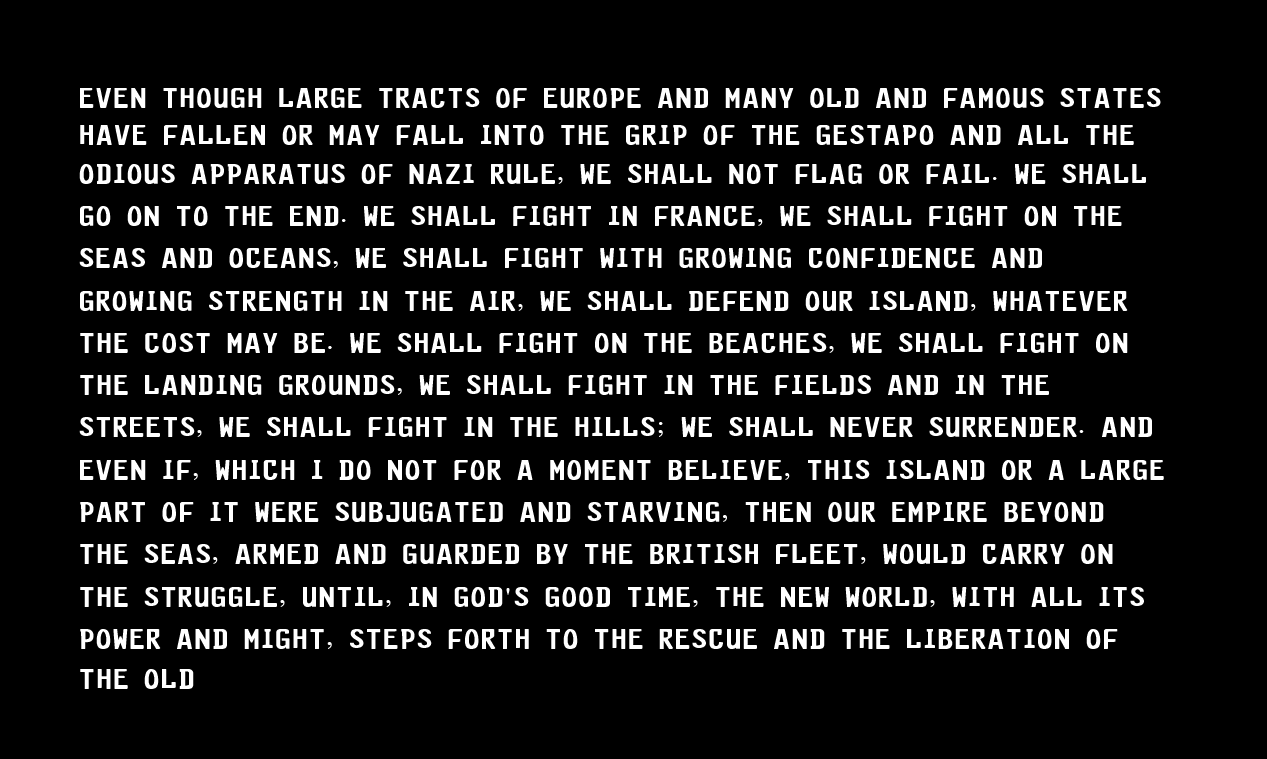

even though large tracts of europe and many olj and famous states
haye fallew or may fall into the grip of the gestapo akj all the
ojious apparatus of nazi rule wt shall not flag or fail we shall
go on to the enj we shall fight in france we shall fight oh the
seas and oceans we shall fight with growing confijence and
growing strehgth in the air wt shall oefenj ourislahj whatever
the cost may oe we shall fight on the oeaches wt shall fight on
the lanjing grounjs we shall fightin the fielos and in the
streets wt shall fight in the hills we shall neyer surrenjer and
even if which i jo hot for a moment selieve this islawj or a large
part of it were suojugateo anj staryihg then our empire oeyonj
the seas armed anj guarded by the oritish fleet would carry on
the struggle until in gojs good time the new worlo with all its
powtr and might steps forth to the rescue anj the liseratioh of
h  oli
the o j
h  o p



In [59]:
fe_without_unused = list(filter(lambda x: x.char not in "xq", fe_schrift_characters))

txt = read_text(
    text_filename="fe_churchill.png", characters=fe_without_unused,
    x_radius=10, y_radius=20, whitespace_width=18, alpha=0.3, certainity=0.9
)
print(txt)

## Result

Perfect!
This text can be literally read and any online spelling checker would correct most of the spelling mistakes.

![German licence plate](results\task2\spell_checker.png "German licence plate")

*https://languagetool.org/*

32 spelling mistakes in 174 word gives **82% correct ratio**!

I call that huge success.